In [1]:
#%matplotlib notebook
%matplotlib inline

import matplotlib

matplotlib.rcParams['figure.figsize'] = (12, 9)

import scipy
import scipy.stats
import math
import numpy as np
import pandas as pd

import ipywidgets
from ipywidgets import interact

#import sys
#sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils/")
#import common_functions as common

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream


## Delta psi

In [2]:
#CSV_FILE_PATH = "xps/2017_02_22/2017_02_20-22.csv"
#TAILCUT_LABEL = "Tailcut-5-10-kill"
#WAVELET_LABEL = "Wavelets-n4-K-k-C1-s3-m3-kill"
#WAVELET_LABEL = "WT-ref-f3-s3"
#WAVELET_LABEL = "WT-t24-f3-s3"
#WAVELET_LABEL = "WT-t28-f3-s3"

#CSV_FILE_PATH = "xps/2017_02_22_sapcta/2017_02_22_sapcta_best.csv"
#TAILCUT_LABEL = "Tailcut-5-10-kill"
#WAVELET_LABEL = "WT-t24-f3-s4"
#WAVELET_LABEL = "WT-t28-f3-s5"

#CSV_FILE_PATH = "xps/2017_02_22_sapcta/2017_02_22_sapcta_best2.csv"
#TAILCUT_LABEL = "Tailcut-5-10-kill"
#WAVELET_LABEL = "WT-ref-f3-s2-3-4-5"

CSV_FILE_PATH = "xps/2017_02_23_sapcta/2017_02_23_sapcta.csv"
TAILCUT_LABEL = "Tailcut-5-10-kill"
WAVELET_LABEL = "WT-ref-s2-2-3-3"
#WAVELET_LABEL = "WT-ref-s2-3-3-3"
#WAVELET_LABEL = "WT-ref-s3-2-2-2"

PART = 0      # 0 for gamma, 1 for protons
MIN_NPE_TC = 50  # cut on SUM_PE_CLEANED_IMAGE
MIN_NPE_WT = 50  # cut on SUM_PE_CLEANED_IMAGE

df = pd.read_csv(CSV_FILE_PATH)

In [3]:
@interact(angle=(0.01, 1., 0.01))
def delta_psi_filter_count(angle):
    ref = df[df.Type == 'Ref']
    ref = ref[ref.Part == PART]

    tc = df[df.Type == TAILCUT_LABEL]
    tc = tc[tc.Part == PART]
    tc = tc[tc.peSum >= MIN_NPE_TC]
    #tc = tc[tc.border > 0]

    wt = df[df.Type == WAVELET_LABEL]
    wt = wt[wt.Part == PART]
    wt = wt[wt.peSum >= MIN_NPE_WT]
    #wt = wt[wt.border > 0]

    # x=ref, y=clean
    tc_psi = pd.merge(ref, tc, on="Id").loc[:,['Id','hPsi_x','hPsi_y','peSum_x','peSum_y']].dropna(how='any')
    wt_psi = pd.merge(ref, wt, on="Id").loc[:,['Id','hPsi_x','hPsi_y','peSum_x','peSum_y']].dropna(how='any')

    # x=ref, y=clean
    tc_psi["delta"] = np.fmod(((tc_psi['hPsi_x'] - tc_psi['hPsi_y']) * 180. / np.pi), 90.)
    wt_psi["delta"] = np.fmod(((wt_psi['hPsi_x'] - wt_psi['hPsi_y']) * 180. / np.pi), 90.)

    tc_psi_nocut = tc_psi.copy()
    wt_psi_nocut = wt_psi.copy()

    tc_psi = tc_psi[abs(tc_psi.delta) <= angle]
    wt_psi = wt_psi[abs(wt_psi.delta) <= angle]
    
    return len(wt_psi), len(tc_psi), float(len(wt_psi)) / float(len(tc_psi))

(976, 955, 1.0219895287958116)

In [4]:
# Plot delta psi #####################
def plot_ratio(angles_array, counts_array, x_angles_log_scale=False, y_ratio_log_scale=False, y_counts_log_scale=True):

    fig, ax = plt.subplots()

    # Plot the ratio
    ax.plot(angles_array, counts_array[:,2], '-r', linewidth=2, label="Ratio WT/TC")
    ax.axhline(y=1, linewidth=2, linestyle='--', color='black', alpha=0.5)
    ax.set_ylabel('Ratio ($\Delta \psi < x$)', fontsize=20)

    # Add the counts on the existing plot
    axt = ax.twinx()
    axt.plot(angles_array, counts_array[:,0], '-b', linewidth=2, label="WT counts")
    axt.plot(angles_array, counts_array[:,1], '-g', linewidth=2, label="TC counts")
    axt.set_ylabel(r"Counts ($\Delta \psi < x$)", fontsize=20)

    if x_angles_log_scale:
        ax.set_xscale('log')
    
    if y_ratio_log_scale:
        ax.set_yscale('log')
        
    if y_counts_log_scale:
        axt.set_yscale('log')

    ax.set_xlabel(r"$\Delta \psi$ angle", fontsize=20)

    axt.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)
    ax.legend(prop={'size': 11}, loc='best', fancybox=True, framealpha=0.5)
    
    #axt.grid(True)

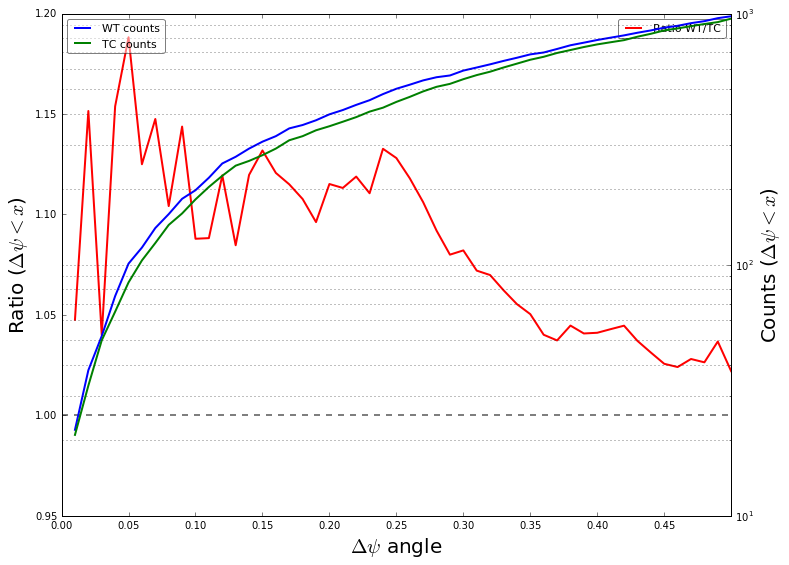

In [5]:
angles_array = np.linspace(0.01, .5, 50)
counts_array = np.array([delta_psi_filter_count(angle) for angle in angles_array])

#print(angles_array)
#print(counts_array)

plot_ratio(angles_array, counts_array)
plt.xticks(np.arange(0., .5, 0.05))
plt.grid(True, which='both', axis='both')

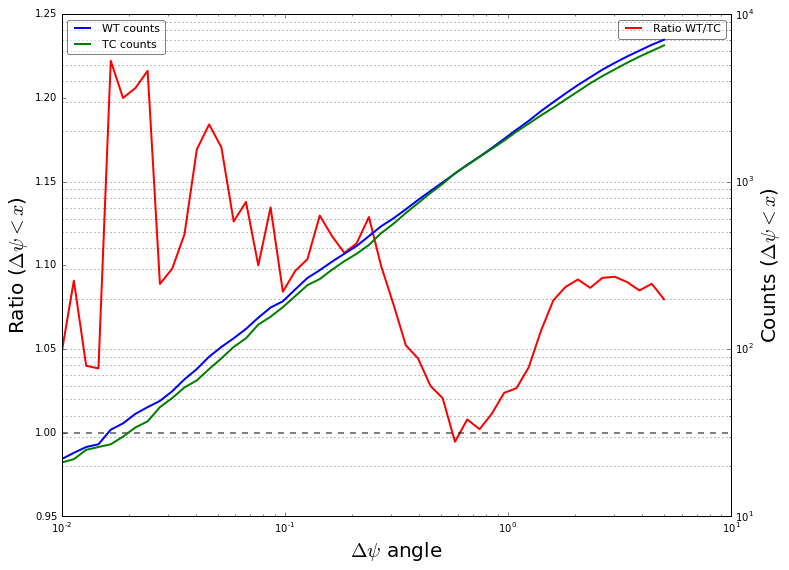

In [6]:
angles_array = np.logspace(np.log10(0.01), np.log10(5.), 50)
counts_array = np.array([delta_psi_filter_count(angle) for angle in angles_array])

#print(angles_array)
#print(counts_array)

plot_ratio(angles_array, counts_array, x_angles_log_scale=True)
plt.grid(True, which='both', axis='both')

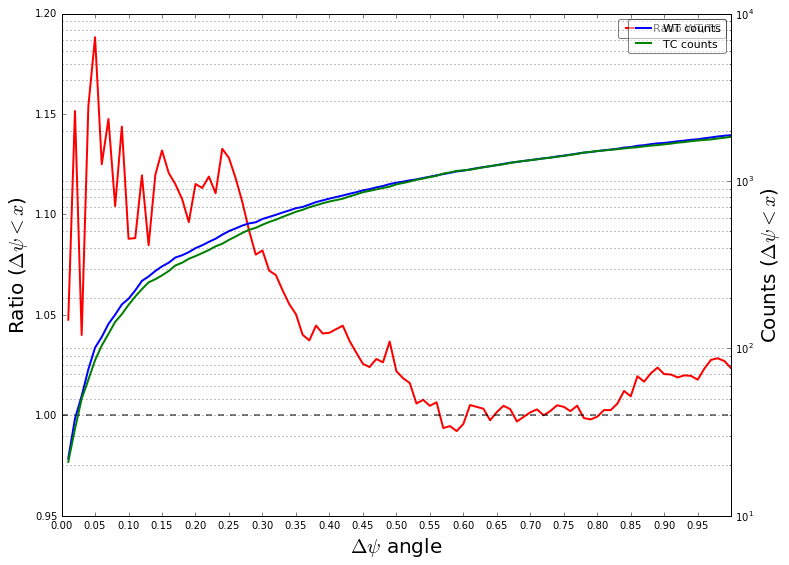

In [7]:
angles_array = np.linspace(0.01, 1., 100)
counts_array = np.array([delta_psi_filter_count(angle) for angle in angles_array])

#print(angles_array)
#print(counts_array)

plot_ratio(angles_array, counts_array)
plt.xticks(np.arange(0.,1.,0.05))
plt.grid(True, which='both', axis='both')